In [8]:
import cirq, sympy
import matplotlib.pyplot as plt

from cirq.contrib.svg import SVGCircuit
%matplotlib inline

In [12]:
# define the length of the grid.
length = 3

# define qubits on the grid.
qubits = cirq.GridQubit.square(length)

print(qubits)
#SVGCircuit(qubits)

[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(1, 0), cirq.GridQubit(1, 1), cirq.GridQubit(1, 2), cirq.GridQubit(2, 0), cirq.GridQubit(2, 1), cirq.GridQubit(2, 2)]


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


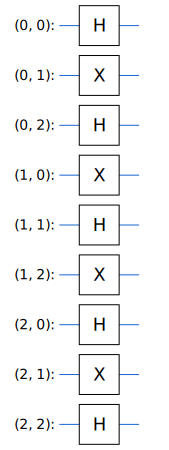

In [17]:
circuit = cirq.Circuit()
circuit.append(cirq.H(q) for q in qubits if (q.row + q.col) % 2 == 0)
circuit.append(cirq.X(q) for q in qubits if (q.row + q.col) % 2 == 1)

SVGCircuit(circuit)

In [18]:
def rot_x_layer(length, half_turns):
    """Yields X rotations by half_turns on a square grid of given length."""

    # Define the gate once and then re-use it for each Operation.
    rot = cirq.XPowGate(exponent=half_turns)

    # Create an X rotation Operation for each qubit in the grid.
    for i in range(length):
        for j in range(length):
            yield rot(cirq.GridQubit(i, j))

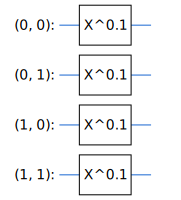

In [19]:
# Create the circuit using the rot_x_layer generator
circuit = cirq.Circuit()
circuit.append(rot_x_layer(2, 0.1))
SVGCircuit(circuit)

In [20]:
import random
def rand2d(rows, cols):
    return [[random.choice([+1, -1]) for _ in range(cols)] for _ in range(rows)]

In [21]:
rand2d(5, 5)

[[-1, -1, -1, -1, 1],
 [-1, 1, -1, 1, 1],
 [1, -1, 1, 1, 1],
 [1, -1, -1, -1, -1],
 [1, -1, -1, 1, -1]]

In [22]:
def random_instance(length):
    # transverse field terms
    h = rand2d(length, length)
    # links within a row
    jr = rand2d(length - 1, length)
    # links within a column
    jc = rand2d(length, length - 1)
    return (h, jr, jc)

In [23]:
h, jr, jc = random_instance(3)
print('transverse fields: {}'.format(h))
print('row j fields: {}'.format(jr))
print('column j fields: {}'.format(jc))

transverse fields: [[1, -1, -1], [1, -1, 1], [-1, 1, -1]]
row j fields: [[-1, 1, -1], [-1, 1, -1]]
column j fields: [[1, 1], [1, -1], [1, -1]]


In [24]:
def rot_z_layer(h, half_turns):
    """Yields Z rotations by half_turns conditioned on the field h."""
    gate = cirq.ZPowGate(exponent=half_turns)
    for i, h_row in enumerate(h):
        for j, h_ij in enumerate(h_row):
            if h_ij == 1:
                yield gate(cirq.GridQubit(i, j))

In [25]:
def rot_11_layer(jr, jc, half_turns):
    """Yields rotations about |11> conditioned on the jr and jc fields."""
    cz_gate = cirq.CZPowGate(exponent=half_turns)    
    for i, jr_row in enumerate(jr):
        for j, jr_ij in enumerate(jr_row):
            q = cirq.GridQubit(i, j)
            q_1 = cirq.GridQubit(i + 1, j)
            if jr_ij == -1:
                yield cirq.X(q)
                yield cirq.X(q_1)
            yield cz_gate(q, q_1)
            if jr_ij == -1:
                yield cirq.X(q)
                yield cirq.X(q_1)

    for i, jc_row in enumerate(jc):
        for j, jc_ij in enumerate(jc_row):
            q = cirq.GridQubit(i, j)
            q_1 = cirq.GridQubit(i, j + 1)
            if jc_ij == -1:
                yield cirq.X(q)
                yield cirq.X(q_1)
            yield cz_gate(q, q_1)
            if jc_ij == -1:
                yield cirq.X(q)
                yield cirq.X(q_1)

In [27]:
def one_step(h, jr, jc, x_half_turns, h_half_turns, j_half_turns):
    length = len(h)
    yield rot_x_layer(length, x_half_turns)
    yield rot_z_layer(h, h_half_turns)
    yield rot_11_layer(jr, jc, j_half_turns)

In [28]:
h, jr, jc = random_instance(3)

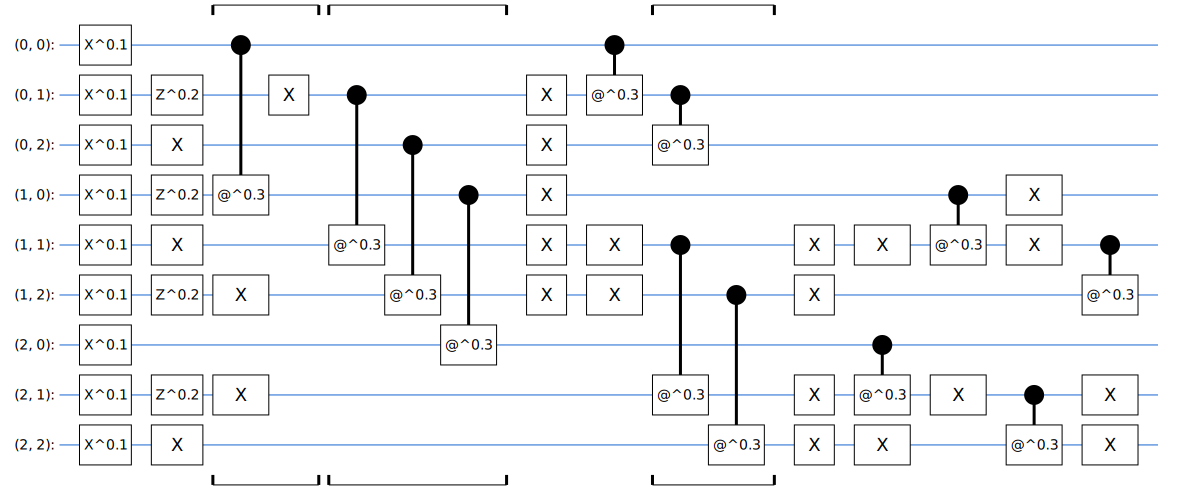

In [29]:
circuit = cirq.Circuit()    
circuit.append(one_step(h, jr, jc, 0.1, 0.2, 0.3),
               strategy=cirq.InsertStrategy.EARLIEST)

SVGCircuit(circuit)